# Test effect of adding prior signal to HMM-GLM on real data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import logit, expit
import ssm

from bfdm import iblmodel

# Load single session

In [2]:
# Load DataFrame
df = pd.read_csv('../data/ibl/test_1.csv', index_col=0);

# Load data from DataFrame into numpy array
data = df[['signed_contrast', 'choice', 'correct_side']].to_numpy()
x = data[:, 0]
y = data[:, 1]
s = data[:, 2]

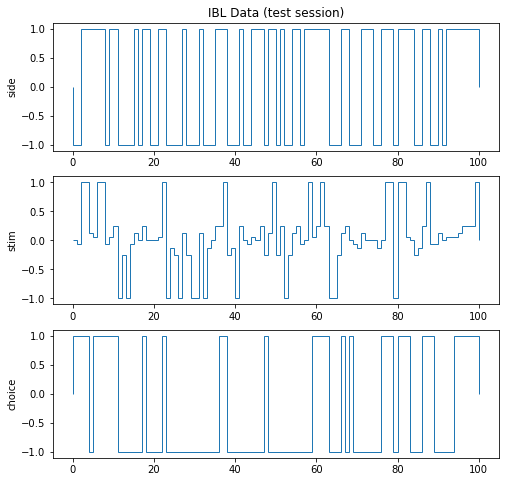

In [13]:
idx = np.s_[0:100]

(fig, ax) = plt.subplots(3, 1, figsize=(8, 8))

ax[0].stairs(s[idx])
ax[0].set_ylabel('side')

ax[1].stairs(x[idx])
ax[1].set_ylabel('stim')

ax[2].stairs(y[idx])
ax[2].set_ylabel('choice')

ax[0].set_title('IBL Data (test session)');

### TODO: Figure this out. Shouldn't there also be x=0.5 and x=0.75 values?

In [7]:
np.unique(x)

array([-1.    , -0.25  , -0.125 , -0.0625,  0.    ,  0.0625,  0.125 ,
        0.25  ,  1.    ])

In [22]:
params = iblmodel.IBLParams(alpha=logit(50/51), beta=logit(0.8), bias=0, coef=1.0)
logit_pos, logit_prior = iblmodel.run_filter(x, s, params)

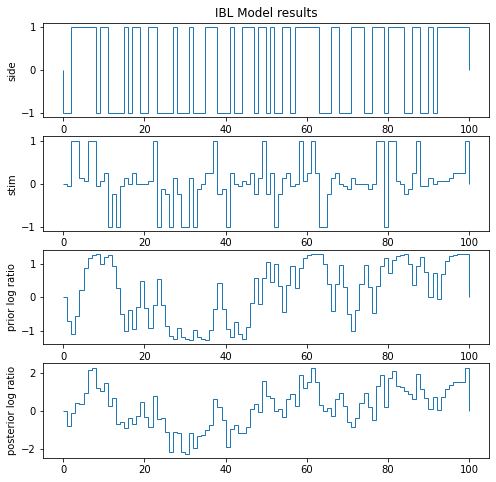

In [23]:
idx = np.s_[0:100]

(fig, ax) = plt.subplots(4, 1, figsize=(8, 8))

ax[0].stairs(s[idx])
ax[0].set_ylabel('side')

ax[1].stairs(x[idx])
ax[1].set_ylabel('stim')

ax[2].stairs(logit_prior[idx])
ax[2].set_ylabel('prior log ratio')

ax[3].stairs(logit_pos[idx])
ax[3].set_ylabel('posterior log ratio')

ax[0].set_title('IBL Model results');

## Create GLM-HMM and fit to data

In [24]:
# Modify inputs for GLM-HMM (need to add column of ones)
x_mod = np.ones((x.shape[0], 3))
x_mod[:, 0] = x
x_mod[:, 1] = logit_prior

# Modify choices for GLM-HMM (y=1 maps to y=0 and y=-1 maps to y=1)
y_mod = np.reshape(y, (-1, 1))
y_mod = (1 - y_mod) / 2
y_mod = y_mod.astype(np.int64)

In [32]:
# Set the parameters of the GLM-HMM
num_states = 2
obs_dim = 1
num_categories = 2
input_dim = 3

# Create GLM-HMM
glm_hmm = ssm.HMM(
    num_states, 
    obs_dim, 
    input_dim, 
    observations="input_driven_obs", 
    observation_kwargs=dict(C=num_categories), 
    transitions="standard"
)

In [33]:
# Number of EM iterations
n_iter = 200

# Fit model
glm_hmm_fit = glm_hmm.fit(
    [y_mod], 
    inputs=[x_mod], 
    method="em", 
    num_iters=n_iter, 
    tolerance=10**-4
)

Converged to LP: -306.2:  20%|██        | 41/200 [00:00<00:03, 49.79it/s]


In [35]:
params = glm_hmm.observations.params
coef_vals = [params[k][0][0] for k in range(num_states)]
bias_vals = [params[k][0][1] for k in range(num_states)]

print('state 0:')
print(f'    coef: {coef_vals[0]:.3f}    bias: {bias_vals[0]:.3f}')
print('state 1:')
print(f'    coef: {coef_vals[1]:.3f}    bias: {bias_vals[1]:.3f}')
#print('state 2:')
#print(f'    coef: {coef_vals[2]:.3f}    bias: {bias_vals[2]:.3f}')

state 0:
    coef: 3.425    bias: 2.650
state 1:
    coef: 6.022    bias: 1.906
